# PyTorch for Deep Learning Bootcamp - Model Deployment Chapter

## 0. Importing dependencies

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from time import time

#now let's import the helper scripts. If not present in the folder, then the scripts will be downloaded from the github repository
try:
    from scripts import dataset_setup
    from scripts import utilities
    from scripts import model_setup
except ImportError:
    print('The helper scripts are not present in the working folder... downloading them from github repository:\n\t'
          'https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke/tree/main/05_PyTorch_Food101/scripts')
    !git clone https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke
    !mv ./PyTorch_Course_by_Daniel_Bourke/05_PyTorch_Food101/scripts .
    !rm -rf ./PyTorch_Course_by_Daniel_Bourke 
    from scripts import dataset_setup
    from scripts import utilities
    from scripts import model_setup
    print('Dependencies properly imported...')

## 1. Creating the datasets and dataloaders

### 1.1 Downloading the data and setting up the Datasets folder

In [2]:
#setting up the folder names
MODEL_FOLDER = Path(os.getcwd() + '/saved_models/new_model')
LOG_FOLDER = MODEL_FOLDER
FOOD101_PATH = Path(os.getcwd() + '/Datasets/food-101') #folder where the original dataset is stored in the
DATASET_TRAIN_FOLDER = Path(os.getcwd() + '/Datasets/train')
DATASET_TEST_FOLDER = Path(os.getcwd() + '/Datasets/final_test')

In [3]:
logger = utilities.Logging_Agent(LOG_FOLDER)
logger

Logging Agent pointing to: /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/08_Model_Deployment/saved_models/new_model

In [4]:
if not DATASET_TEST_FOLDER.parent.exists():
    os.mkdir(DATASET_TEST_FOLDER.parent)
    print('Dataset folder created...')
    

## 2. Importing the ViT Model (already trained)

## 2.a Re-creating a feature extractor which can import the data of the pretrained model (ViT Model)

In [5]:
vit_model_pretrained = model_setup.ViT_B_16(name='ViT_model_pretrained')

In [6]:
import torchinfo

BATCH_SIZE = 2 ** 5
torchinfo.summary(model=vit_model_pretrained,
                  input_size=(BATCH_SIZE, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
ViT_B_16                                           [32, 3, 224, 224]         [32, 1000]                --                        True
├─VisionTransformer: 1-1                           [32, 3, 224, 224]         [32, 1000]                768                       True
│    └─Conv2d: 2-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
│    └─Encoder: 2-2                                [32, 197, 768]            [32, 197, 768]            151,296                   True
│    │    └─Dropout: 3-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    │    └─Sequential: 3-2                        [32, 197, 768]            [32, 197, 768]            85,054,464                True
│    │    └─LayerNorm: 3-3                         [32, 197

In [7]:
for param in vit_model_pretrained.parameters():
    param.requires_grad = False

In [8]:
#before overwriting the head, the pretrained model shows the following final block
vit_model_pretrained.pre_trained_model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [9]:
vit_model_pretrained.pre_trained_model.heads = nn.Linear(
    in_features=768,
    out_features=5,
    bias=True
)

vit_model_pretrained.pre_trained_model.heads

Linear(in_features=768, out_features=5, bias=True)

In [10]:
torchinfo.summary(model=vit_model_pretrained,
                  input_size=(BATCH_SIZE, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
ViT_B_16                                           [32, 3, 224, 224]         [32, 5]                   --                        Partial
├─VisionTransformer: 1-1                           [32, 3, 224, 224]         [32, 5]                   768                       Partial
│    └─Conv2d: 2-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
│    └─Encoder: 2-2                                [32, 197, 768]            [32, 197, 768]            151,296                   False
│    │    └─Dropout: 3-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    │    └─Sequential: 3-2                        [32, 197, 768]            [32, 197, 768]            (85,054,464)              False
│    │    └─LayerNorm: 3-3                        

In [11]:
import pathlib

VIT_FILE = pathlib.Path('/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/07_PyTorch_PaperReplicating/saved_models/ViT-B-16-pretrained/model_checkpoint_epoch_20.pt')
with open(VIT_FILE, 'rb') as f:
    checkpoint = torch.load(f)
    
vit_model_pretrained.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [12]:
vit_model_pretrained

ViT_B_16(
  (pre_trained_model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (l

## 2.b Re-creating a feature extractor which can import the data of the pretrained model (EffNetB2)

In [13]:
effnet_b2_pretrained = model_setup.EffNetB2(name='EfficientNetB2')

In [14]:
for param in effnet_b2_pretrained.features.parameters():
    param.requires_grad = False

### Resetting the classifier layer

In [15]:
#checking the dimension of the output of the model down to the avgpooling layer, in order to set properly the head of the model when it comes to talk of transfer learning
effnet_b2_pretrained.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [16]:
effnet_b2_pretrained.classifier = nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=5, bias=True)
)
effnet_b2_pretrained.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1408, out_features=5, bias=True)
)

In [17]:
torchinfo.summary(effnet_b2_pretrained,
                  input_size=(1, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable']
                  )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
EffNetB2                                 [1, 3, 224, 224]          [1, 5]                    --                        Partial
├─ModuleList: 1-1                        --                        --                        --                        Partial
│    └─Sequential: 2-1                   [1, 3, 224, 224]          [1, 1408, 7, 7]           7,700,994                 False
│    └─Conv2dNormActivation: 2-2         [1, 3, 224, 224]          [1, 32, 112, 112]         928                       False
│    └─Conv2d: 2-3                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    └─BatchNorm2d: 2-4                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    └─SiLU: 2-5                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                      

In [18]:
import pathlib

EFFNET_B2_FILE = pathlib.Path('/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/06_PyTorch_TransferLearning/saved_models/EffNet_b2_augm/model_checkpoint_epoch_20.pt')
with open(EFFNET_B2_FILE, 'rb') as f:
    checkpoint = torch.load(f)
    
effnet_b2_pretrained.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

## 3. Setting up the Datasets and Dataloaders

#### We must build the datasets with the specific transform recipe for the two models, since the pipeline used is not the same:
#### **Here is the ViT**
<img src='https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke/raw/main/08_Model_Deployment/notebook_pictures/08_Torchvision_ViT_transform_pipeline.png'>

#### **Here is the EffNetB2**
<img src='https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke/raw/main/08_Model_Deployment/notebook_pictures/08_Torchvision_EffNetB2_transform_pipeline.png'>


### 3.1 ViT transforms pipeline

In [19]:
#this is the recipe for the ViT transformers since it achieved the best performance in terms of accuracy so far
ViT_RESIZE = (256, 256)

vit_transform = nn.Sequential(
    v2.ToImage(),
    v2.Resize(ViT_RESIZE),
    v2.CenterCrop(size=224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
)

In [20]:
vit_test_dataset = ImageFolder(
    root=DATASET_TEST_FOLDER,
    transform=vit_transform,
)
BATCH_SIZE = 2 ** 4

#the whole dataloader for the whole test set is needed because we want to compare the accuracy of both the models ==> a larger number of picture is needed
vit_test_dataloader = DataLoader(
    dataset=vit_test_dataset,
    shuffle=True,
    drop_last=True,
    batch_size=BATCH_SIZE
)

#### as always let's visualize what we are importing to check if it is consistent with our expectactions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8431373..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6855742..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2489083].


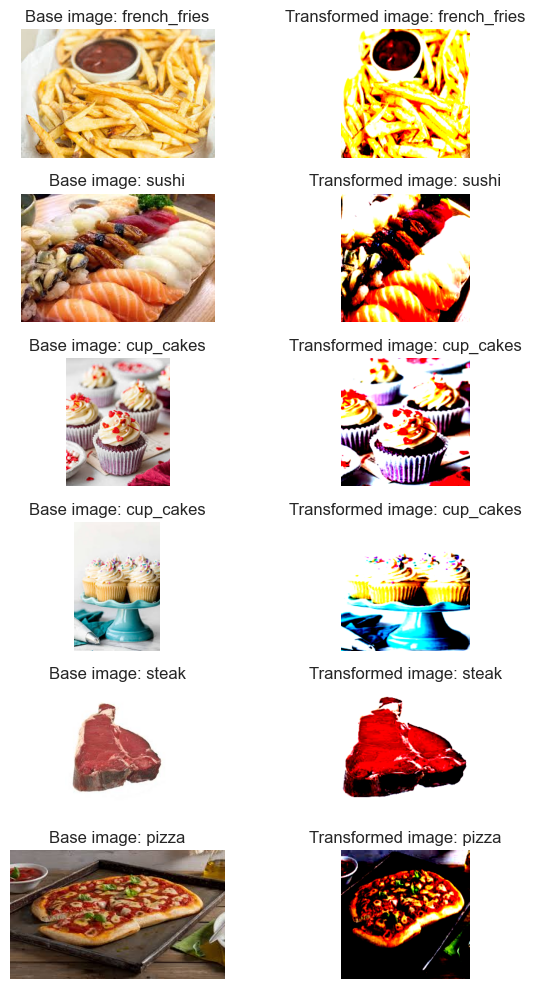

In [21]:
utilities.plot_samples_transformed(
    path=DATASET_TEST_FOLDER,
    classes_names=vit_test_dataset.classes,
    transform=vit_transform
)

### 3.2 EffNetB2 transforms pipeline

In [22]:
#this is the recipe for the ViT transformers since it achieved the best performance in terms of accuracy so far
EffNetB2_RESIZE = (288, 288)

effnetb2_transform = nn.Sequential(
    v2.ToImage(),
    v2.Resize(ViT_RESIZE),
    v2.CenterCrop(size=288),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
)

In [23]:
effnetb2_test_dataset = ImageFolder(
    root=DATASET_TEST_FOLDER,
    transform=effnetb2_transform,
)

#the whole dataloader for the whole test set is needed because we want to compare the accuracy of both the models ==> a larger number of picture is needed
effnetb2_test_dataloader = DataLoader(
    dataset=effnetb2_test_dataset,
    shuffle=True,
    drop_last=True,
    batch_size=BATCH_SIZE
)

#### as always let's visualize what we are importing to check if it is consistent with our expectactions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5354254].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


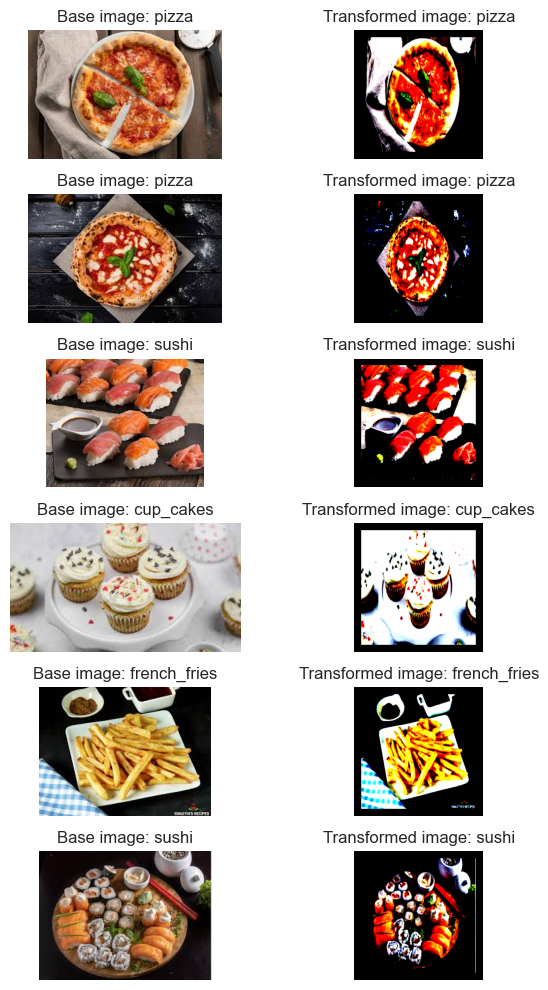

In [24]:
utilities.plot_samples_transformed(
    path=DATASET_TEST_FOLDER,
    classes_names=effnetb2_test_dataset.classes,
    transform=effnetb2_transform
)

## 4. Testing the models

In [25]:
#setting device agnostic code
device = 'mps' if torch.mps.is_available() else 'cpu'
print('The available device is {}'.format(device))

The available device is mps


In [26]:
loss_function = nn.CrossEntropyLoss()

### 4.1 EffNetB2 Model evaluation

In [27]:
effnet_b2_pretrained.to(device)

EffNetB2(
  (architecture): ModuleList(
    (0): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          

In [28]:
effnet_b2_pretrained.eval()
with torch.no_grad():
    accuracy = []
    prediction = None
    targets = None
    inference_time = []
    for pics_batch, target_batch in vit_test_dataloader:
        pics_batch, target_batch = pics_batch.to(device), target_batch.to(device)
        
        inference_time_start = time()
        batch_test_loss, batch_test_acc, batch_pred = effnet_b2_pretrained.eval_step(
            batch_test_X=pics_batch,
            batch_test_y=target_batch,
            loss_foo=loss_function,
            device=device,
            return_pred=True
        )
        inference_time_end = time()
        
        inference_time.append(inference_time_end - inference_time_start)
        accuracy.append(batch_test_acc)
        if prediction is None:
            prediction = batch_pred.unsqueeze(1)
            targets = target_batch.unsqueeze(1)
        else:
            prediction = torch.vstack((prediction, batch_pred.unsqueeze(1)))
            targets = torch.vstack((targets, target_batch.unsqueeze(1)))
    
    avg_inference_time = sum(inference_time) / len(inference_time) / BATCH_SIZE
    accuracy = np.mean(accuracy)
    prediction = prediction.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    print(f'{vit_model_pretrained.name} | The accuracy of the model on a brand new set of samples is: {accuracy:.3%}')
    print(f'The average inference time per itmem is {avg_inference_time:.3f}')

/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/08_Model_Deployment/scripts/model_setup.py:183: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = torch.argmax(nn.functional.softmax(y_hat_cv), dim=1)


ViT_model_pretrained | The accuracy of the model on a brand new set of samples is: 88.393%
The average inference time per itmem is 0.005


In [29]:
sum_params = 0 #initializing a number to hold the overall number of params in the model and finally make a comparison

for param in effnet_b2_pretrained.parameters():
    sum_params += param.numel()
sum_params = sum_params / 1e6 #getting the millions of params

effnet_b2_resume = {
    'accuracy': accuracy,
    'inference_time_per_item': avg_inference_time,
    'millions_of_params': sum_params,
}

effnet_b2_resume

{'accuracy': np.float64(0.8839285714285714),
 'inference_time_per_item': 0.005415818520954677,
 'millions_of_params': 9.117039}

Text(0.5, 1.0, 'Confusion Matrix')

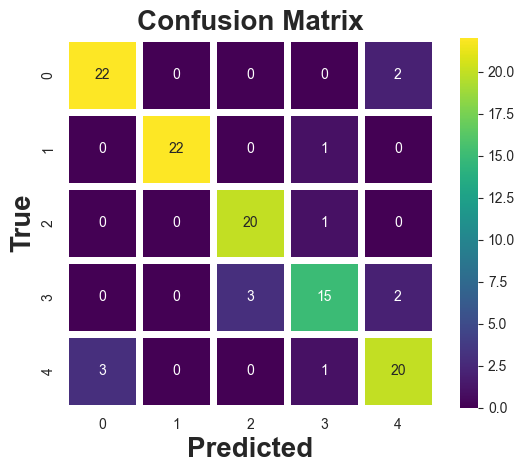

In [30]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
heatmap(
    confusion_matrix(targets, prediction),
    square=True,
    cmap='viridis',
    annot=True,
    linewidths=5,
    linecolor='white',
)
plt.xlabel('Predicted', fontsize=20, fontweight='bold')
plt.ylabel('True', fontsize=20, fontweight='bold')
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')

### 4.2 ViT Model evaluation

In [31]:
vit_model_pretrained.to(device)

ViT_B_16(
  (pre_trained_model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (l

In [32]:
vit_model_pretrained.eval()
with torch.no_grad():
    accuracy = []
    prediction = None
    targets = None
    inference_time = []
    for pics_batch, target_batch in vit_test_dataloader:
        pics_batch, target_batch = pics_batch.to(device), target_batch.to(device)
        
        inference_time_start = time()
        batch_test_loss, batch_test_acc, batch_pred = vit_model_pretrained.eval_step(
            batch_test_X=pics_batch,
            batch_test_y=target_batch,
            loss_foo=loss_function,
            device=device,
            return_pred=True
        )
        inference_time_end = time()
        
        inference_time.append(inference_time_end - inference_time_start)
        accuracy.append(batch_test_acc)
        if prediction is None:
            prediction = batch_pred.unsqueeze(1)
            targets = target_batch.unsqueeze(1)
        else:
            prediction = torch.vstack((prediction, batch_pred.unsqueeze(1)))
            targets = torch.vstack((targets, target_batch.unsqueeze(1)))
    
    avg_inference_time = sum(inference_time) / len(inference_time) / BATCH_SIZE
    accuracy = np.mean(accuracy)
    prediction = prediction.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    print(f'{vit_model_pretrained.name} | The accuracy of the model on a brand new set of samples is: {accuracy:.3%}')
    print(f'The average inference time per item is {avg_inference_time:.3f}')

/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/08_Model_Deployment/scripts/model_setup.py:183: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = torch.argmax(nn.functional.softmax(y_hat_cv), dim=1)


ViT_model_pretrained | The accuracy of the model on a brand new set of samples is: 95.536%
The average inference time per item is 0.014


In [33]:
sum_params = 0 #initializing a number to hold the overall number of params in the model and finally make a comparison

for param in vit_model_pretrained.parameters():
    sum_params += param.numel()
sum_params = sum_params / 1e6 #getting the millions of params

vit_resume = {
    'accuracy': accuracy,
    'inference_time_per_item': avg_inference_time,
    'millions_of_params': sum_params,
}

vit_resume

{'accuracy': np.float64(0.9553571428571429),
 'inference_time_per_item': 0.01378296741417476,
 'millions_of_params': 85.802501}

Text(0.5, 1.0, 'Confusion Matrix')

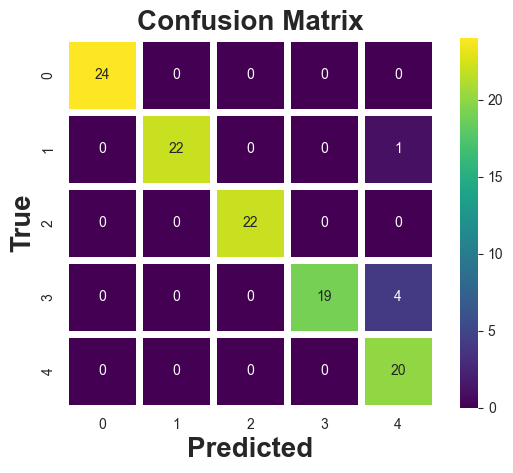

In [34]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
heatmap(
    confusion_matrix(targets, prediction),
    square=True,
    cmap='viridis',
    annot=True,
    linewidths=5,
    linecolor='white',
)
plt.xlabel('Predicted', fontsize=20, fontweight='bold')
plt.ylabel('True', fontsize=20, fontweight='bold')
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')